# IND320 CA1 Ivar Eftedal

### Use of AI

### Log of compulsary work


### Experience with jupiter notebook and streamlit
- I must also say that i am still somewhat frustrated having to work with jupiter notebooks, but i think i have finally found a setup that works fairly well, which should make it simpler for the next assignment. Streamlit was still nice to work with.

### Links:
- [GitHub](https://github.com/ioeftedal/ind320ioeftedal)
- https://github.com/ioeftedal/ind320ioeftedal
- [Streamlit](https://ind320ioeftedal.streamlit.app)
- https://ind320ioeftedal.streamlit.app

## Getting into the code:

### Import dependencies

In [169]:
import openmeteo_requests
import requests_cache

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from retry_requests import retry
from pygments.lexers import go
from scipy.fftpack import dct, idct
from statsmodels.tsa.seasonal import STL
from sklearn.neighbors import LocalOutlierFactor
from scipy.signal import spectrogram

### Function for API dowload

In [170]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

def save_data(latitude: float, longitude: float, year) -> pd.DataFrame:
    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    """ Change the url to fetch the data we need"""
    url = "https://archive-api.open-meteo.com/v1/era5"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": [
            "temperature_2m",
            "precipitation",
            "wind_speed_10m",
            "wind_gusts_10m",
            "wind_direction_10m"
        ],
        "models": "era5",
        "start_date": f"{year}-01-01",
        "end_date": f"{year}-12-31",
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation: {response.Elevation()} m asl")
    print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_precipication = hourly.Variables(1).ValuesAsNumpy()
    hourly_wind_speed_10m = hourly.Variables(2).ValuesAsNumpy()
    hourly_wind_gusts_10m = hourly.Variables(3).ValuesAsNumpy()
    hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()

    hourly_data = {"date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    ), "temperature_2m": hourly_temperature_2m, "precipication": hourly_precipication,
        "wind_speed_10m": hourly_wind_speed_10m, "wind_gusts_10m": hourly_wind_gusts_10m,
        "wind_direction_10m": hourly_wind_direction_10m}

    hourly_dataframe = pd.DataFrame(data = hourly_data)

    return hourly_dataframe


### Running the function

Coordinates: 60.5°N 5.25°E
Elevation: 17.0 m asl
Timezone difference to GMT+0: 0s
                       date  temperature_2m  precipication  wind_speed_10m  \
0 2019-01-01 00:00:00+00:00            6.55            0.5       47.959782   
1 2019-01-01 01:00:00+00:00            6.80            0.9       48.621330   
2 2019-01-01 02:00:00+00:00            6.85            0.7       52.638840   
3 2019-01-01 03:00:00+00:00            6.55            0.6       55.753529   
4 2019-01-01 04:00:00+00:00            6.20            1.0       55.531094   

   wind_gusts_10m  wind_direction_10m  
0       87.839996          277.765076  
1       80.279999          296.375275  
2       85.320000          310.006195  
3       98.639999          314.215271  
4      119.519997          317.101654  


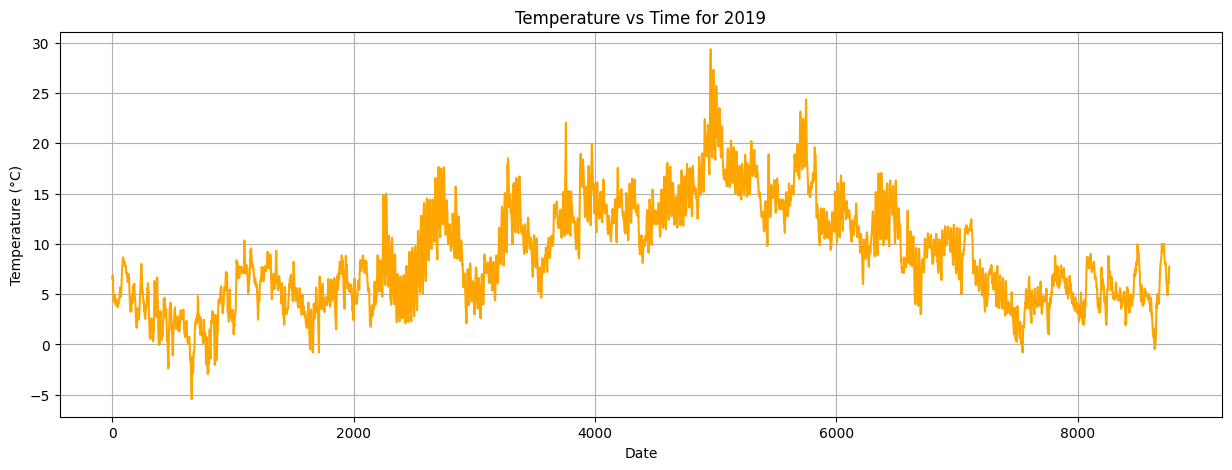

In [171]:
bergen2019 = save_data(60.3929, 5.32415, 2019)

print(bergen2019.head())

plt.figure(figsize=(15,5))
plt.plot(bergen2019.index, bergen2019['temperature_2m'], color='orange')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature vs Time for 2019')
plt.grid(True)
plt.show()

In [172]:
def detect_weather_anomalies(df,
    temp_col='temperature_2m',
    precip_col='precipication',
    cutoff=100,
    std_mult=2,
    lof_frac=0.01):
    """
    Detect temperature outliers (DCT + SPC) and precipitation anomalies (LOF).
    """
    df = df.copy()
    df = df.sort_values('date')
    time = pd.to_datetime(df['date'])

    # Temperature Outliers (DCT + SPC)
    temp = df[temp_col].values
    dct_coeff = dct(temp, norm='ortho')

    # Low-frequency trend
    dct_low = np.copy(dct_coeff)
    dct_low[cutoff:] = 0
    trend = idct(dct_low, norm='ortho')

    # High-frequency component (SATV)
    satv = temp - trend

    # Robust statistics (median + MAD)
    med_satv = np.median(satv)
    mad_satv = np.median(np.abs(satv - med_satv))
    upper_band = trend + std_mult * mad_satv
    lower_band = trend - std_mult * mad_satv

    # Detect outliers
    mask_temp_out = (temp > upper_band) | (temp < lower_band)
    temp_outliers = df.loc[mask_temp_out, ['date', temp_col]]

    # Precipitation Anomalies (LOF)
    precip = df[precip_col].values.reshape(-1, 1)
    lof = LocalOutlierFactor(contamination=lof_frac)
    labels = lof.fit_predict(precip)
    mask_precip_out = labels == -1
    precip_outliers = df.loc[mask_precip_out, ['date', precip_col]]

    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Temperature plot
    ax1.plot(time, temp, label='Temperature (°C)', color='tab:blue', alpha=0.8)
    ax1.plot(time, trend, color='orange', label='Trend (low-freq)')
    ax1.plot(time, upper_band, 'g--', label=f'+{std_mult}σ (robust)')
    ax1.plot(time, lower_band, 'g--')
    ax1.scatter(temp_outliers['date'], temp_outliers[temp_col],
        color='red', label='Outliers', zorder=5)
    ax1.fill_between(time, lower_band, upper_band, color='green', alpha=0.1)
    ax1.set_title('Temperature Outlier Detection (DCT + Robust SPC)')
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.4)

    # Precipitation plot
    ax2.plot(time, df[precip_col], color='tab:gray', label='Precipitation')
    ax2.scatter(precip_outliers['date'], precip_outliers[precip_col],
        color='red', label='LOF anomalies', zorder=5)
    ax2.set_title('Precipitation Anomaly Detection (Local Outlier Factor)')
    ax2.set_ylabel('Precipitation (mm)')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.4)
    ax2.set_xlabel('Date')

    fig.tight_layout()

    summaries = {
        'temperature_outliers': temp_outliers,
        'precip_anomalies': precip_outliers
    }

    return fig, [ax1, ax2], summaries


/Users/ivareftedal/repositories/github.com/ioeftedal/ind320ioeftedal/.venv/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


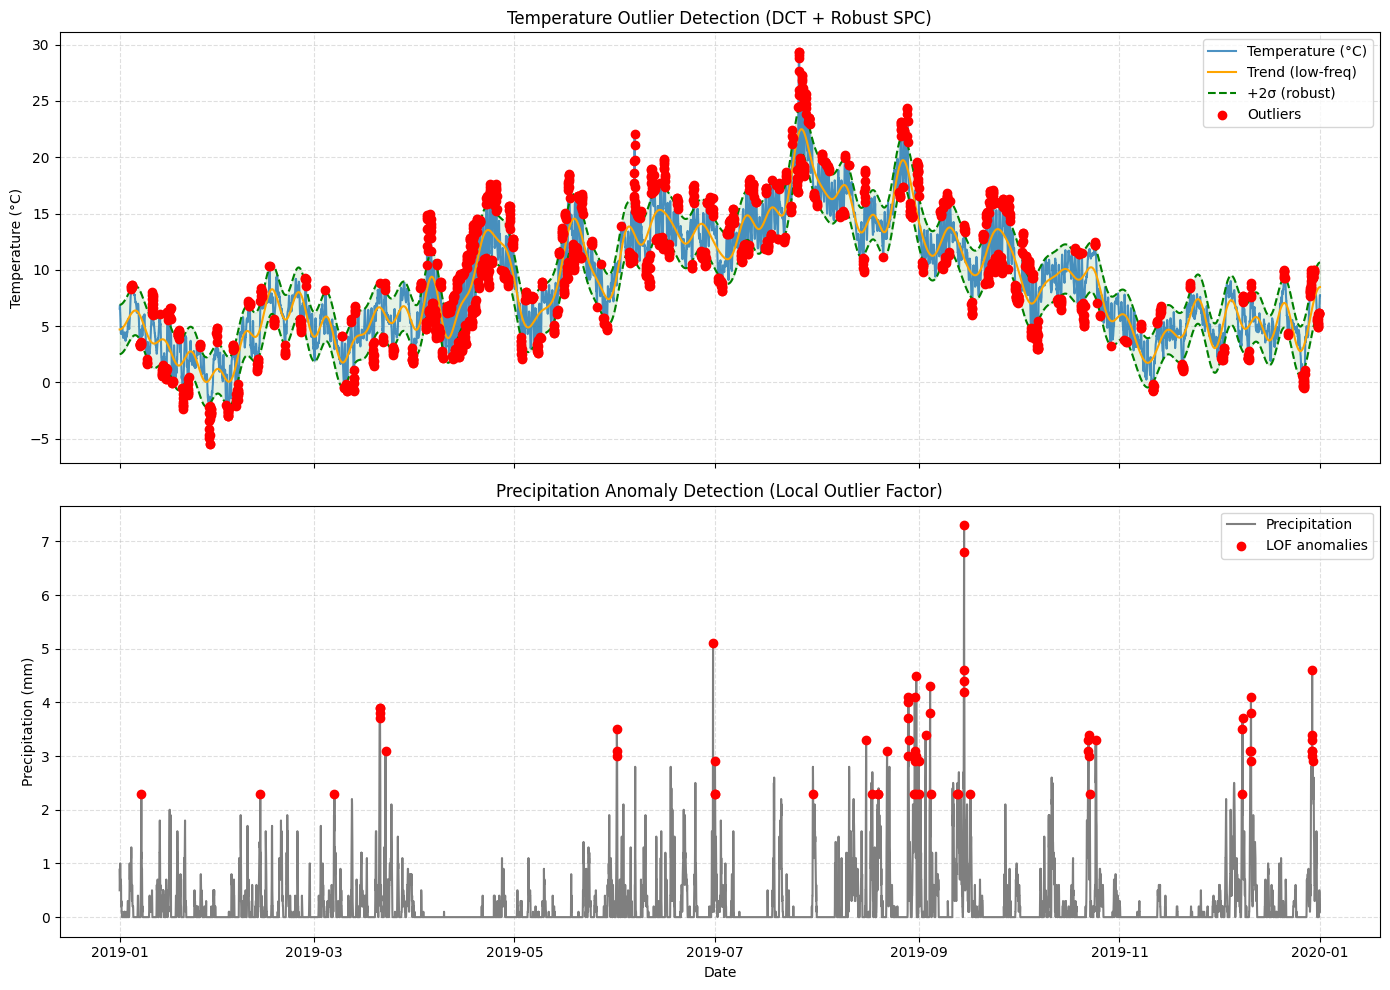

Temperature Outliers:
                        date  temperature_2m
84 2019-01-04 12:00:00+00:00            8.30
85 2019-01-04 13:00:00+00:00            8.45
86 2019-01-04 14:00:00+00:00            8.55
87 2019-01-04 15:00:00+00:00            8.65
88 2019-01-04 16:00:00+00:00            8.65
Precipitation Anomalies:
                          date  precipication
158  2019-01-07 14:00:00+00:00            2.3
1026 2019-02-12 18:00:00+00:00            2.3
1567 2019-03-07 07:00:00+00:00            2.3
1897 2019-03-21 01:00:00+00:00            3.9
1898 2019-03-21 02:00:00+00:00            3.8


In [173]:
fig, axes, summaries = detect_weather_anomalies(bergen2019)
plt.show()

# Display outlier summaries
print("Temperature Outliers:")
print(summaries['temperature_outliers'].head())

print("Precipitation Anomalies:")
print(summaries['precip_anomalies'].head())


### STL Decomposition

In [174]:
def decompose_production_stl(df,
    area='NO1',
    group='hydro',
    period=24,
    seasonal=7,
    trend=73,
    robust=True,
    figsize=(16, 10)):
    """
    Perform STL decomposition (Seasonal-Trend decomposition using LOESS)
    on Elhub production data and plot results.
    """

    # Filter Data (if needed)
    df = df.copy()
    if 'area' in df.columns:
        df = df[df['area'] == area]
    if 'group' in df.columns:
        df = df[df['group'] == group]

    # Assume 'value' is the production measurement column
    value_col = 'value' if 'value' in df.columns else 'temperature_2m'
    df = df.sort_values('date')
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    # STL decomposition
    stl = STL(df[value_col], period=period,
        seasonal=seasonal, trend=trend, robust=robust)
    result = stl.fit()

    # Plot
    fig = result.plot()
    fig.set_size_inches(figsize)
    fig.suptitle(f"STL Decomposition for {group} in {area}", fontsize=16)
    fig.tight_layout()

    return fig, result


### Running the code

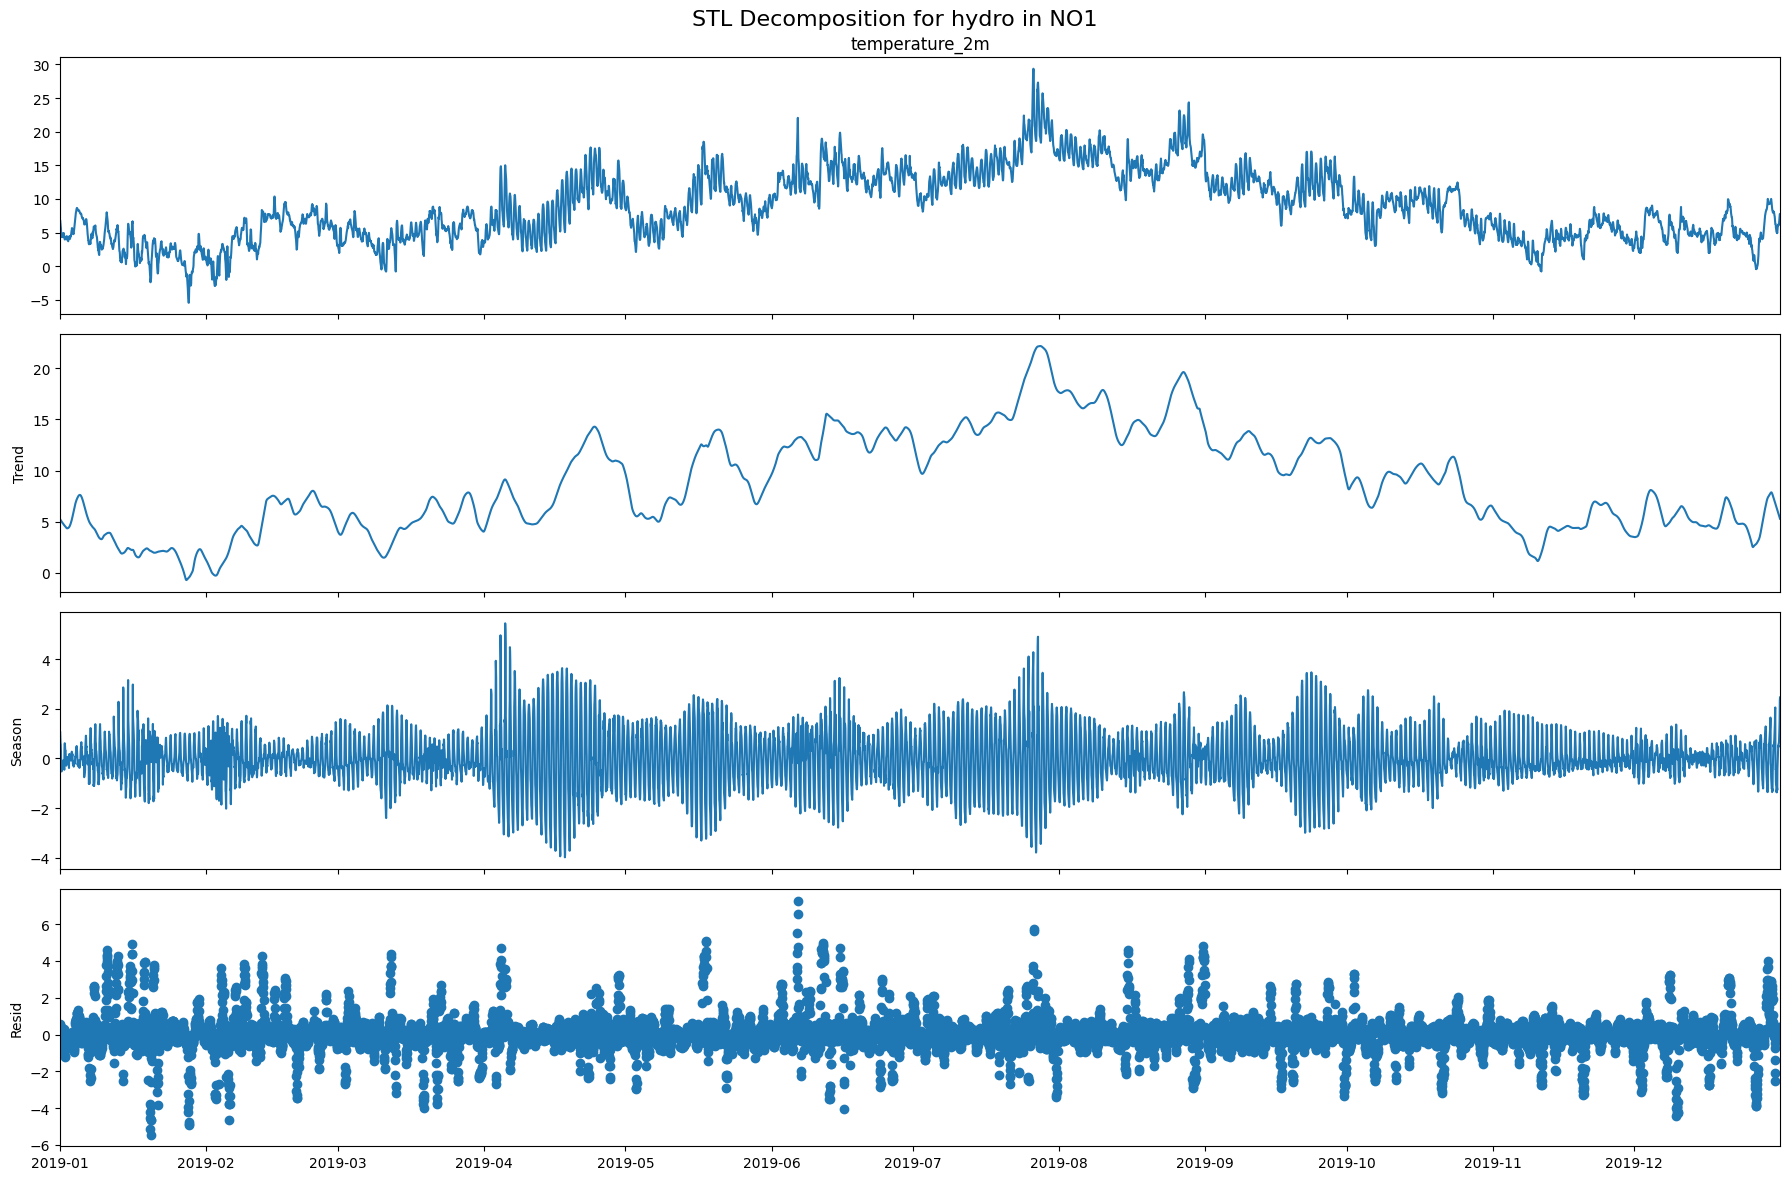

In [175]:
fig, stl_result = decompose_production_stl(bergen2019, figsize=(18, 12))
plt.show()

### Spectrogram

In [176]:
def plot_production_spectrogram(df: pd.DataFrame,
    area: str ='NO1',
    group: str ='hydro',
    window_length=256,
    overlap=128):
    """
    Create and plot a spectrogram of Elhub production data.
    """

    df = df.copy()
    if 'area' in df.columns:
        df = df[df['area'] == area]
    if 'group' in df.columns:
        df = df[df['group'] == group]

    value_col = 'value' if 'value' in df.columns else 'temperature_2m'
    df = df.sort_values('date')
    values = df[value_col].values

    #Compute spectrogram
    fs = 1  # sampling frequency (1 sample per hour if hourly)
    f, t, Sxx = spectrogram(values, fs=fs,
    nperseg=window_length,
    noverlap=overlap,
    scaling='density')

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    pcm = ax.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-12),
        shading='gouraud', cmap='viridis')
    ax.set_ylabel('Frequency [cycles/hour]')
    ax.set_xlabel('Time [samples]')
    ax.set_title(f"Spectrogram of {group} in {area}")
    fig.colorbar(pcm, ax=ax, label='Power (dB)')
    fig.tight_layout()

    return fig, (f, t, Sxx)


### Running the function

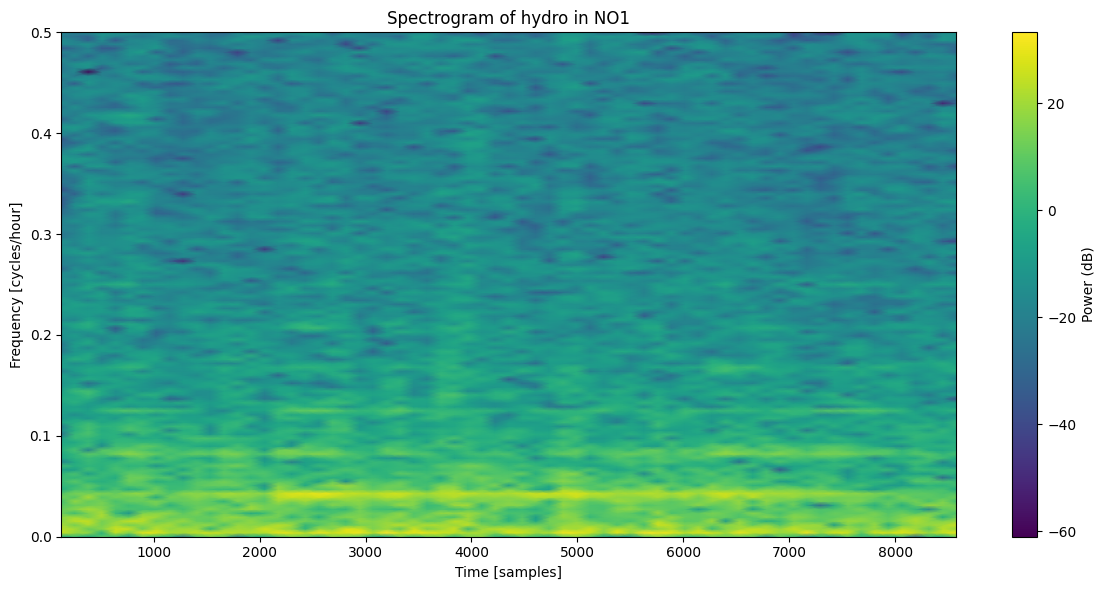

In [177]:
fig, (f, t, Sxx) = plot_production_spectrogram(bergen2019)
plt.show()